# Version 11 7-17-24
* proof of concept in working order to demonstrate potential methodology to agentic patterns.

# Self RAG using local LLMs

Self-RAG is a strategy for RAG that incorporates self-reflection / self-grading on retrieved documents and generations. 

THIS VERSION USES
* local host ollama   llama3
* nomic embeddings
* Chroma DB
* Jupyter Notebook
* Python 3.12.3
* Dependencies listed in Environment section
* Self RAG MEthod
* [LangGraph](https://langchain-ai.github.io/langgraph/).
Credit to original template: (https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_self_rag/) would recomend looking at other methods


In the this test the attempt is to be able to do the following.

1. Should I retrieve from retriever, `R` -

* Input: `x (question)` OR `x (question)`, `y (generation)`
* Decides when to retrieve `D` chunks with `R`
* Output: `yes, no, continue`

2. Are the retrieved passages `D` relevant to the question `x` -

* * Input: (`x (question)`, `d (chunk)`) for `d` in `D`
* `d` provides useful information to solve `x`
* Output: `relevant, irrelevant`

3. Are the LLM generation from each chunk in `D` is relevant to the chunk (hallucinations, etc)  -

* Input: `x (question)`, `d (chunk)`,  `y (generation)` for `d` in `D`
* All of the verification-worthy statements in `y (generation)` are supported by `d`
* Output: `{fully supported, partially supported, no support`

4. The LLM generation from each chunk in `D` is a useful response to `x (question)` -

* Input: `x (question)`, `y (generation)` for `d` in `D`
* `y (generation)` is a useful response to `x (question)`.
* Output: `{5, 4, 3, 2, 1}`


CURRENT VERSION DOES NOT INCLUDE JAIL BREAK DETECTION



![Screenshot 2024-04-01 at 12.42.59 PM.png]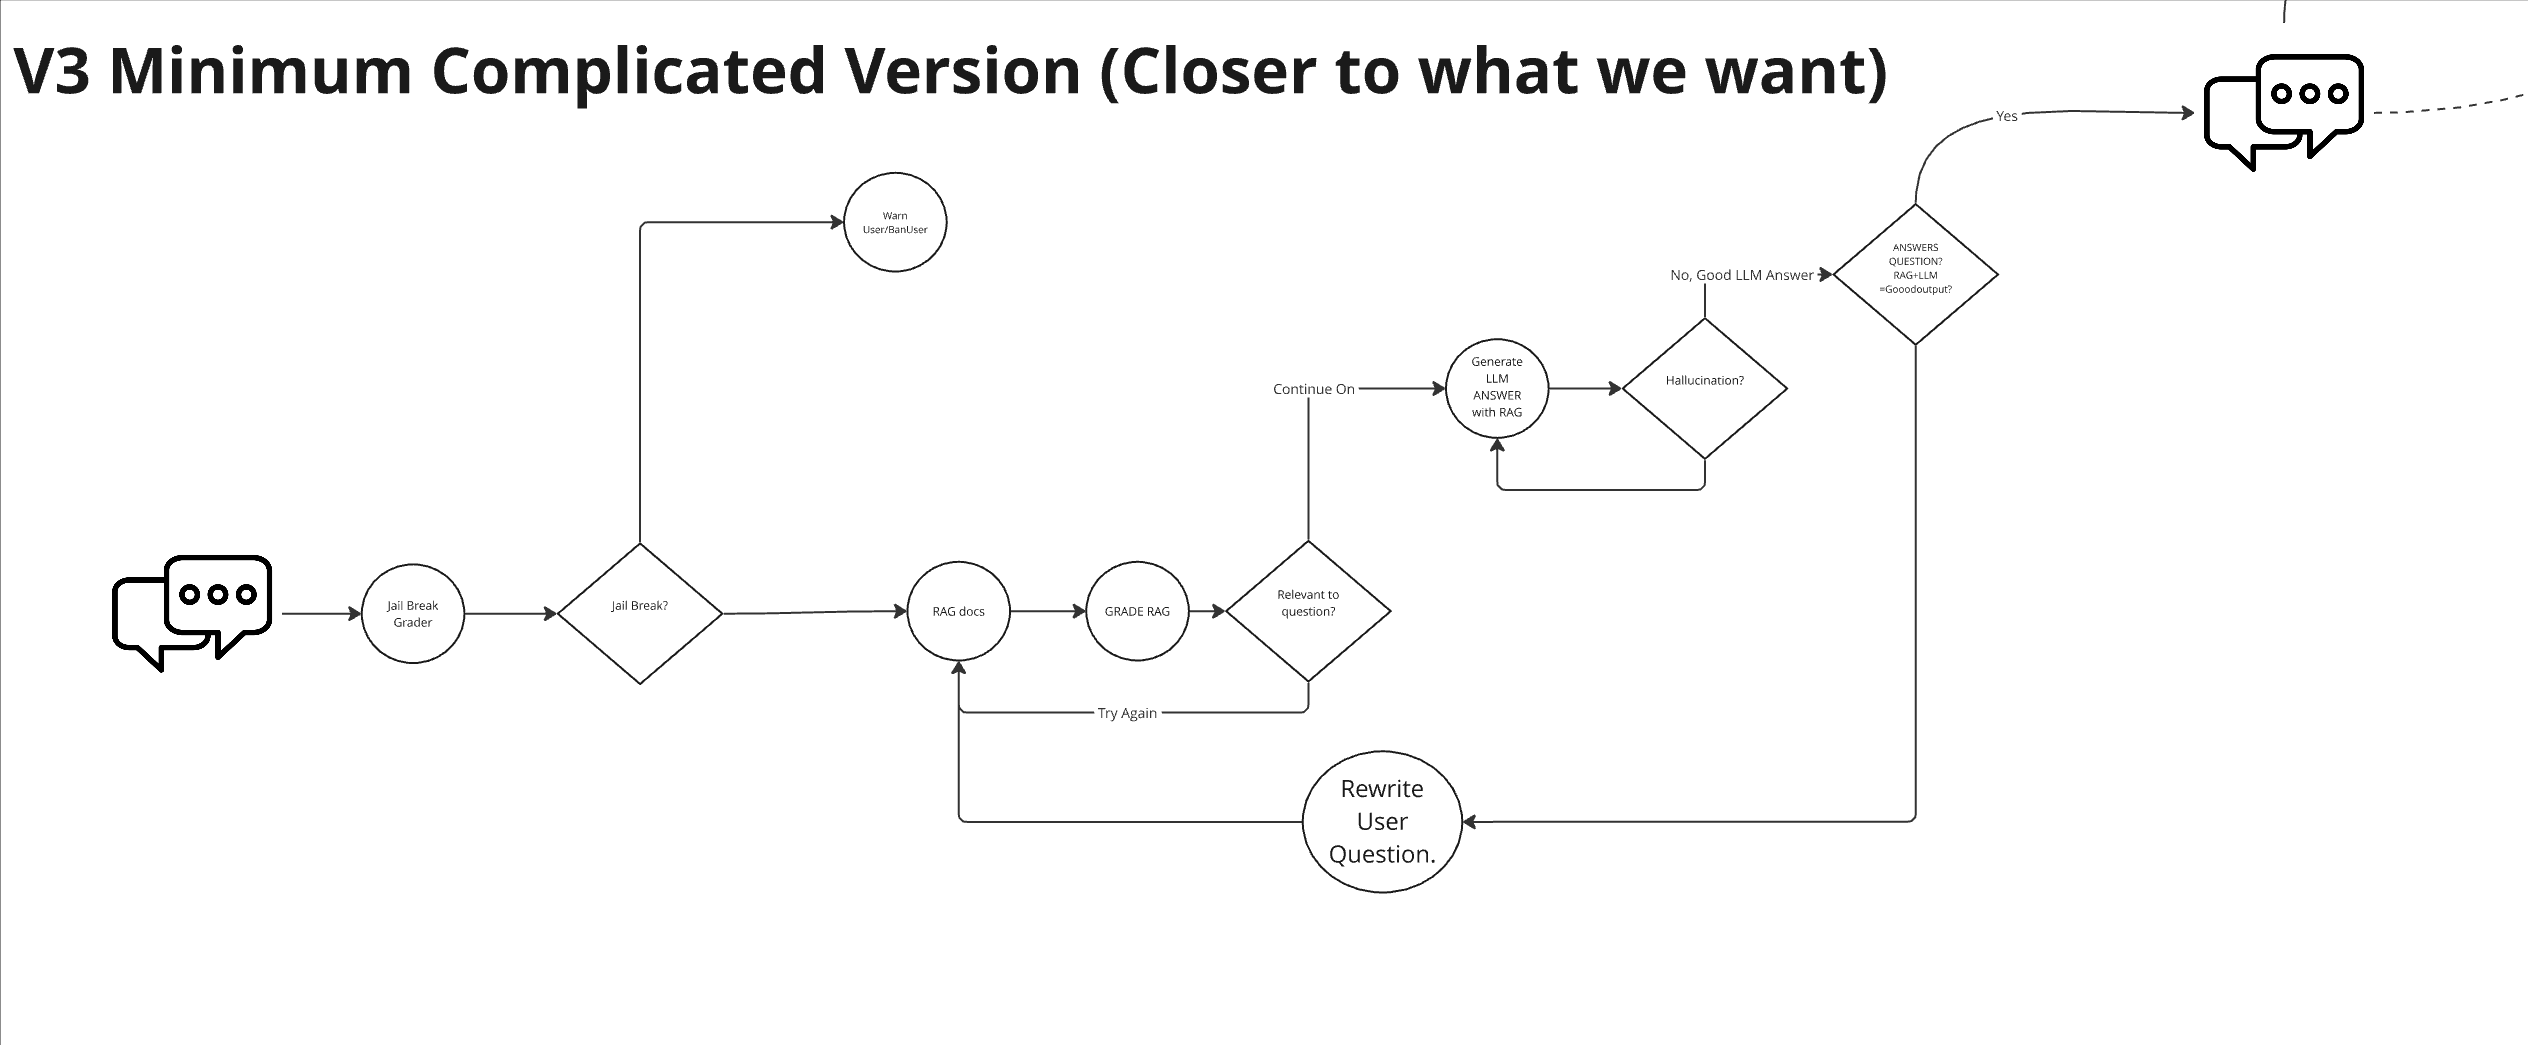

# Known Issues
So far we only get a limited amount of options on Love in the book of John, this mayb be because
* not all files are being read in the John File when indexing
* this sits closer to the center of the book and it may have issues with retrevial
* other reason I'm not sure yet and am still researching

# Environment 

In [4]:
%%capture --no-stderr
%pip install -U langchain-nomic langchain_community tiktoken langchainhub chromadb langchain langgraph nomic[local] jupyter-resource-usage psutil

In [5]:
import sys
import subprocess

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

required_packages = [
    'langchain-community', 'langchain-nomic', 'langchain_text_splitters', 
    'chromadb', 'tiktoken', 'psutil'
]

for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        install_package(package)


Installing langchain-community...
Installing langchain-nomic...


# Check Library Compatibility

In [6]:
import pkg_resources

required_packages = [
    'langchain-community', 'langchain-nomic', 'langchain_text_splitters', 
    'chromadb', 'tiktoken', 'psutil'
]

def check_version_compatibility():
    for package in required_packages:
        try:
            version = pkg_resources.get_distribution(package).version
            print(f"{package}: {version}")
        except pkg_resources.VersionConflict:
            print(f"Warning: Version conflict for {package}")

check_version_compatibility()


langchain-community: 0.2.7
langchain-nomic: 0.1.2
langchain_text_splitters: 0.2.2
chromadb: 0.5.4
tiktoken: 0.7.0
psutil: 5.9.8


C:\Users\Jacob Lehman\AppData\Local\Temp\ipykernel_6008\4176361524.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


# Incrase Jupyter Resources

In [7]:
import os
os.environ['JUPYTER_RESOURCE_USAGE_MAX_MEMORY'] = '8G'  # Adjust as needed

Print Memory Usage

In [8]:
import psutil
import os

def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Current memory usage: {process.memory_info().rss / 1024 / 1024:.2f} MB")


Run in Batches to handle load

In [9]:
def process_files_in_batches(dir_path, batch_size=100):
    all_files = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]
    for i in range(0, len(all_files), batch_size):
        batch = all_files[i:i+batch_size]
        yield batch

In [10]:
import pickle

def save_checkpoint(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

def load_checkpoint(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

### LLMs

#### Local Embeddings

You can use `GPT4AllEmbeddings()` from Nomic, which can access use Nomic's recently released [v1](https://blog.nomic.ai/posts/nomic-embed-text-v1) and [v1.5](https://blog.nomic.ai/posts/nomic-embed-matryoshka) embeddings.


Follow the documentation [here](https://docs.gpt4all.io/gpt4all_python_embedding.html#supported-embedding-models).

#### Local LLM

(1) Download [Ollama app](https://ollama.ai/).

(2) Download a `Mistral` model from various Mistral versions [here](https://ollama.ai/library/mistral) and Mixtral versions [here](https://ollama.ai/library/mixtral) available.
```
ollama pull mistral
```

In [11]:
# Ollama model name
local_llm = "llama3"

### Tracing

Optionally, use [LangSmith](https://docs.smith.langchain.com/) for tracing (shown at bottom)

In [12]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "<YOUR_API_KEY>"

## Indexing John KJV.

# experiementation v11 made 7-17-24

hopefully this works for you by this point (I had the most issue with this step) this part below was the fuzziest for me in my area of knowledge 

In [13]:
import gc
from langchain_community.vectorstores import Chroma
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.schema import Document

def read_bible_file(file_path):
    documents = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                reference, text = parts
                doc = Document(
                    page_content=text,
                    metadata={"reference": reference, "source": file_path}
                )
                documents.append(doc)
    return documents

# Define the path to your text files
dir_path = r"C:\Users\Jacob Lehman\Documents\CODE_TEST_CURRENT\7-16-24\John"
checkpoint_file = 'checkpoint.pkl'

# Load checkpoint if exists
if os.path.exists(checkpoint_file):
    checkpoint = load_checkpoint(checkpoint_file)
    start_index = checkpoint['index']
    bible_documents = checkpoint['data']
else:
    start_index = 0
    bible_documents = []

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=50
)
embedding = NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local")
vectorstore = Chroma(collection_name="rag-chroma", embedding_function=embedding)

for batch in process_files_in_batches(dir_path):
    for chapter_file in batch:
        file_path = os.path.join(dir_path, chapter_file)
        bible_documents.extend(read_bible_file(file_path))
    
    doc_splits = text_splitter.split_documents(bible_documents)
    vectorstore.add_documents(doc_splits)
    
    # Save checkpoint
    save_checkpoint({'index': len(bible_documents), 'data': bible_documents}, checkpoint_file)
    
    print(f"Processed {len(doc_splits)} document chunks.")
    print_memory_usage()
    gc.collect()  # Force garbage collection

retriever = vectorstore.as_retriever()

# Example of retrieving similar documents
query = "What does Jesus say about love?"
similar_docs = retriever.get_relevant_documents(query)
print(f"Found {len(similar_docs)} relevant documents for the query: '{query}'")
for doc in similar_docs[:3]:  # Print the first 3 relevant documents
    print(f"Reference: {doc.metadata['reference']}")
    print(f"Content: {doc.page_content[:100]}...")  # Print first 100 characters
    print()

print_memory_usage()


Processed 3516 document chunks.
Current memory usage: 1095.22 MB
Found 4 relevant documents for the query: 'What does Jesus say about love?'
Reference: John 14:23
Content: Jesus answered and said unto him, If a man love me, he will keep my words: and my Father will love h...

Reference: John 14:23
Content: Jesus answered and said unto him, If a man love me, he will keep my words: and my Father will love h...

Reference: John 14:23
Content: Jesus answered and said unto him, If a man love me, he will keep my words: and my Father will love h...

Current memory usage: 1095.13 MB


c:\Users\Jacob Lehman\AppData\Local\Programs\Python\Python312\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


#May take 7 to 10 minutes at the most

## LLMs

In [25]:
### Retrieval Grader

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=1.0) # NOTICE HIGH TEMPERATURE TEMPROARILY PUT IN PLACE TO SEE IF IT WILL PASS BETTER

# More lenient prompt template
prompt = PromptTemplate(
    template="""You are a grader assessing the relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains any keywords or concepts that are even loosely related to the user question, grade it as relevant. It does not need to be an exact match; a close match is sufficient. \n
    The goal is to filter out only the most irrelevant retrievals. \n
    Give a binary score 'yes' or 'no' to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

{'score': 'yes'}


In [15]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOllama(model=local_llm, temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Define the new question
question = "What does the Bible say about love?"

#define docs
docs = retriever.get_relevant_documents(question)

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)


According to the Bible, Jesus says that if someone loves Him, they will keep His words, and as a result, God will love them and make their home with them (John 14:23). This suggests that loving God is not just an emotional feeling, but also involves obedience to His teachings.


Index Creation: The first code block (INDEX CODE BLOCK) is responsible for creating the RAG index. It reads Bible documents, splits them into chunks, embeds them using NomicEmbeddings, and stores them in a Chroma vector store.
Retriever Setup: At the end of the INDEX CODE BLOCK, a retriever is created from the vector store:

python
retriever = vectorstore.as_retriever()

Retrieval Grader: The RETRIEVAL GRADER BLOCK sets up a system to grade the relevance of retrieved documents. It uses the retriever created earlier:

python
docs = retriever.get_relevant_documents(question)

RAG Generation: In the GENERATE ANSWER BLOCK, the RAG system is used to generate an answer. The key parts are:

python
# Prompt
prompt = hub.pull("rlm/rag-prompt")

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})

    Here, docs is assumed to be the retrieved documents from the earlier retrieval step.

The system is using RAG in the following way:

    It retrieves relevant documents based on the question.
    These documents are passed as context to the language model.
    The language model then generates an answer based on both the question and the retrieved context.


In [16]:
### Hallucination Grader

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is grounded in / supported by a set of facts. \n 
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}
    Give a binary score 'yes' or 'no' score to indicate whether the answer is grounded in / supported by a set of facts. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'score': 'yes'}

In [17]:
### Answer Grader

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is useful to resolve a question. \n 
    Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question}
    Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

{'score': 'yes'}

In [18]:
### Question Re-writer

# LLM
llm = ChatOllama(model=local_llm, temperature=0)

# Prompt
re_write_prompt = PromptTemplate(
    template="""You a question re-writer that converts an input question to a better version that is optimized \n 
     Look at the initial and formulate an improved question. that is gospel and user focoused for edification \n
     Here is the initial question: \n\n {question}. Improved question with no preamble: \n """,
    input_variables=["generation", "question"],
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

"Here's a rewritten version of the question:\n\nWhat are the key biblical teachings on love, and how do they define its nature, characteristics, and expressions?\n\nThis improved question:\n\n* Is more specific and focused on the topic of love\n* Asks for concrete information (biblical teachings) rather than a general overview\n* Encourages exploration of the depth and complexity of the concept of love in the Bible\n* Provides a clear direction for the answer to provide insight into the nature, characteristics, and expressions of love"

## Everything above provides a foundational concept that could be extended to incorporate more advanced memory features.
For more advanced agent memory systems, you would need to implement additional components such as:

    Persistent storage for long-term memory
    Mechanisms for updating and managing stored information
    More sophisticated retrieval methods for accessing relevant information
    Potentially, different types of memory (e.g., episodic, semantic) as described in some of the search results



# Graph 

Capture the flow in as a graph.

## Graph state

In [19]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [20]:
### Nodes


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

## Build Graph

This just follows the flow we outlined in the figure above.

In [21]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

## Run


In [27]:
from pprint import pprint

# Run
inputs = {"question": "What does the Bible say about love?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('According to the Bible, Jesus says that if someone loves Him, they will keep '
 'His words, and as a result, God will love them and make their home with them '
 '(John 14:23). This suggests that loving God is not just an emotional '
 'feeling, but also involves obedience to His teachings.')


Cell Output Example Previous Run

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('According to the Bible, Jesus says that if someone loves Him, they will keep '
 'His words, and as a result, God will love them and make their home with them '
 '(John 14:23). This suggests that loving God is not just an emotional '
 'feeling, but also involves obedience to His teachings.')


# look here for Tracing: 

https://smith.langchain.com/o/5795c7a4-3d5f-52af-9c93-8599b323eed9/projects/p/260f049d-fc4f-451b-9f30-863baf716394?timeModel=%7B%22duration%22%3A%227d%22%7D